## Pokemon Goa Trip

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image

### Data Preparation

In [183]:
from pathlib import Path

In [184]:
p=Path('./Images/')

image_data={}
dirs=p.glob('*')

for img_path in dirs:
    ids=str(img_path).split("\\")[1]
    img=image.load_img(img_path,target_size=(50,50),)
    arr_img=image.img_to_array(img,dtype='float32')/255.0
    image_data[ids]=arr_img
        


C:\Users\SS\Anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [185]:
image_data['296.jpg'].shape

(50, 50, 3)

In [186]:
dfx=pd.read_csv("./train.csv")
dfx.head()

,ImageId,NameOfPokemon
0,296.jpg,Pikachu
1,297.jpg,Pikachu
2,298.jpg,Pikachu
3,299.jpg,Pikachu
4,300.jpg,Pikachu


In [187]:
from sklearn.preprocessing import LabelEncoder

In [188]:
le=LabelEncoder()

In [189]:
dfx['NameOfPokemon']=le.fit_transform(dfx['NameOfPokemon'])

In [190]:
dfx.head()

,ImageId,NameOfPokemon
0,296.jpg,2
1,297.jpg,2
2,298.jpg,2
3,299.jpg,2
4,300.jpg,2


In [191]:
classes=le.classes_
classes

array(['Bulbasaur', 'Charmander', 'Pikachu'], dtype=object)

In [192]:
no_classes=len(classes)
no_classes

3

In [193]:
### Shuffling Data
dfx=dfx.sample(frac=1).reset_index(drop=True)

In [194]:
dfx.head()

,ImageId,NameOfPokemon
0,552.jpg,1
1,396.jpg,2
2,527.jpg,1
3,589.jpg,1
4,346.jpg,2


In [195]:
dfx.shape

(304, 2)

In [196]:
labels=dfx['NameOfPokemon']
image_id=dfx['ImageId']

In [197]:
print(image_id[1])
print(labels[1])

396.jpg
2


In [198]:
img_arr=[]
for i in range(dfx.shape[0]):
    img_arr.append(image_data[image_id[i]])

In [199]:
img_arr[0].shape

(50, 50, 3)

In [200]:
img_arr=np.array(img_arr)
labels=np.array(labels)
print(img_arr.shape,labels.shape)

(304, 50, 50, 3) (304,)


In [201]:
M=img_arr.shape[0]
img_arr=img_arr.reshape((M,-1))
print(img_arr.shape)
print(labels.shape)

(304, 7500)
(304,)


### visulization

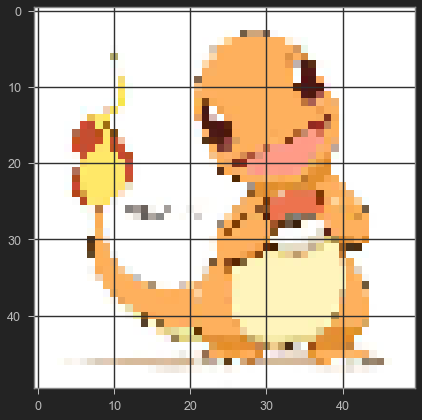

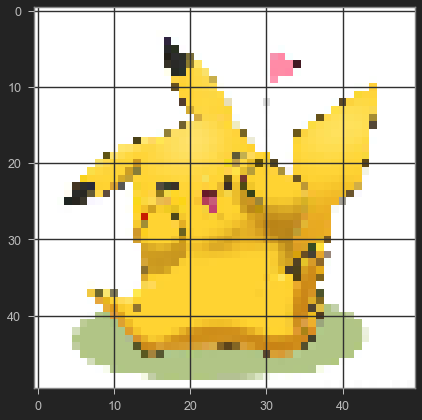

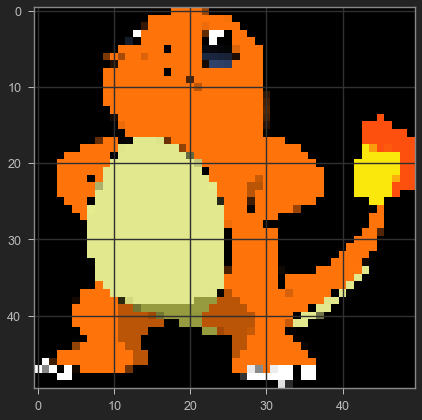

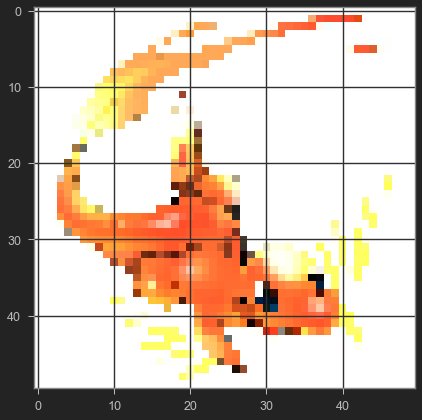

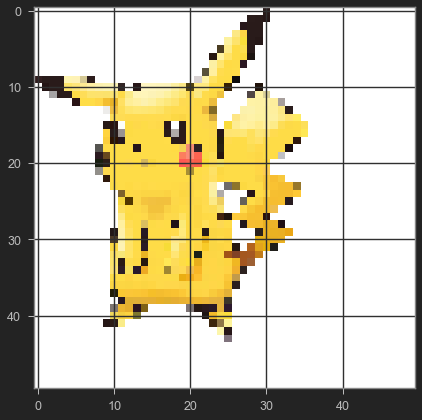

In [202]:
def plotImage(img):
    plt.imshow(img)
    plt.show()
    return

for i in range(5):
    plotImage(image_data[image_id[i]])

### SVM Model

In [275]:
class SVM:
    
    def __init__(self,no_classes,c=1.0):
        
        self.c=c
        self.w=0
        self.b=0
        self.no_classes=no_classes
        self.svm_classifiers={}
        self.losses=0
        
    def loss(self,w,b,X,Y):
        
        loss_=0.0
        
        loss_+=.5*np.dot(w,w.T)
        
        m=X.shape[0]
        
        for i in range(m):
            ti=Y[i]*(np.dot(w,X[i].T)+b)
            loss_+=self.c*max(0,1-ti)
            
        return loss_[0][0]
    
    def fit(self,X,Y,fold_size=100,learning_rate=0.0001,max_iteration=1000):
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        
        n=learning_rate
        c=self.c
        
        w=np.zeros((1,no_of_features))
        b=0
        
        losses=[]
        
        for i in range(max_iteration):
            
            l=self.loss(w,b,X,Y)
            losses.append(l)
            
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0,no_of_samples,fold_size):
                
                grad_w=0
                grad_b=0
                
                for j in range(batch_start,batch_start+fold_size):
                        if j<no_of_samples:
                            i=ids[j]
                            ti=Y[i]*(np.dot(w,X[i].T)+b)

                            if ti>1:
                                grad_w+=0
                                grad_b+=0
                            else:
                                grad_w+=c*Y[i]*X[i]
                                grad_b+=c*Y[i]
                                
                w = w - n*w + n*grad_w
                b = b + n*grad_b
                
        self.w=w
        self.b=b
        self.losses=losses
        return w,b,losses
    
    def classWiseData(self,x,y):
        data={}
        for i in range(self.no_classes):
            data[i]=[]
        for i in range(x.shape[0]):
            data[y[i]].append(x[i])
        for k in data.keys():
            data[k]=np.array(data[k])
        return data
    
    def getDataPair(self,d1,d2):
    
        l1,l2=d1.shape[0],d2.shape[0]

        sample=l1+l2
        feature=d1.shape[1]

        data_pair=np.zeros((sample,feature))
        data_label=np.zeros((sample,))

        data_pair[:l1,:]=d1
        data_pair[l1:,:]=d2

        data_label[:l1]=-1
        data_label[l1:]=+1

        return data_pair,data_label
    
    def trainSVM(self,X,Y):
    
        svm_classifiers={}
        
        data=self.classWiseData(X,Y)
        
        for i in range(self.no_classes):

            svm_classifiers[i]={}

            for j in range(i+1,self.no_classes):

                xpair,ypair=self.getDataPair(data[i],data[j])
                wts,b,loss=self.fit(xpair,ypair)
                svm_classifiers[i][j]=(wts,b)
                
        self.svm_classifiers=svm_classifiers
        return svm_classifiers
    
    def binaryPredict(self,X,w,b):
        z=np.dot(X,w.T)+b

        if(z>=0):
            return 1
        else:
            return 0
        
    def predict(self,X):
    
        count=np.zeros((self.no_classes,))

        for i in range(self.no_classes):

            for j in range(i+1,self.no_classes):
                w,b=self.svm_classifiers[i][j]

                z=self.binaryPredict(X,w,b)

                if(z==1):
                    count[j]+=1
                else:
                    count[i]+=1
        final_prediction=np.argmax(count)
        return final_prediction

In [276]:
svm_=SVM(no_classes)

### Training data

In [277]:
svm_.trainSVM(img_arr,labels)

{0: {1: (array([[-0.00219057,  0.00179494,  0.00594349, ..., -0.00487881,
           -0.00043794,  0.00568004]]),
   0.0033999999999999963),
  2: (array([[ 3.20614261e-04,  2.41380176e-03,  4.94810201e-03, ...,
           -9.95898160e-05,  1.01996065e-03,  5.58253771e-03]]),
   -0.019599999999999992)},
 1: {2: (array([[ 0.00796631,  0.00609954,  0.00033516, ...,  0.01042866,
            0.00559352, -0.00193007]]),
   -0.05429999999999983)},
 2: {}}

### testing data

In [206]:
df_test=pd.read_csv("./test.csv")

In [207]:
df_test.head()

,ImageId
0,1106.jpg
1,2236.jpg
2,1131.jpg
3,2221.jpg
4,2011.jpg


In [208]:
df_test.shape

(123, 1)

In [228]:
test_arr=[]
for i in range(df_test.shape[0]):
    test_arr.append(image_data[df_test['ImageId'][i]])

In [229]:
test_arr=np.array(test_arr)
test_arr.shape

(123, 50, 50, 3)

In [230]:
M=test_arr.shape[0]
test_arr=test_arr.reshape((M,-1))

In [231]:
test_arr.shape

(123, 7500)

In [278]:
predict=[]
for i in range(df_test.shape[0]):
    predict.append(svm_.predict(test_arr[i]))

In [279]:
predict=le.inverse_transform(predict)

In [273]:
ImageId=df_test['ImageId']

In [280]:
predict=pd.DataFrame({'ImageId':ImageId,'NameOfPokemon':predict})
predict.to_csv("submission_scratch.csv",index=False)

### ----------     97% Accuracy with Scratch    -----

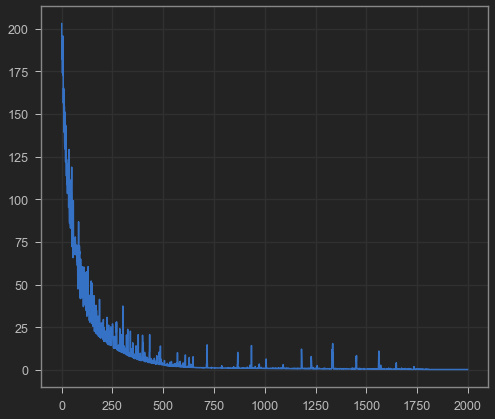

In [270]:
plt.plot(svm_.losses)

### Inbuilt Classifier SVM

In [213]:
from sklearn import svm

In [214]:
svm_classifier=svm.SVC(C=1.0)

In [215]:
svm_classifier.fit(img_arr,labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [224]:
predict1=svm_classifier.predict(test_arr)

In [225]:
predict1=le.inverse_transform(predict1)

In [226]:
prediction=pd.DataFrame({'ImageId':ImageId,'NameOfPokemon':predict1})
prediction.to_csv("submission_inbuilt_svm.csv",index=False)

### 85% accuracy

## using Grid search

In [241]:
from sklearn.model_selection import GridSearchCV

In [242]:
params = [
    {
        'kernel':['linear','rbf','poly','sigmoid'],
        'C':[0.1,0.2,0.5,1.0,2.0,5.0]
    }
]

In [243]:
import multiprocessing

In [244]:
cpus=multiprocessing.cpu_count()
print(cpus)

8


In [245]:
gs=GridSearchCV(estimator=svm.SVC(),param_grid=params,scoring='accuracy',cv=5,n_jobs=cpus)

In [246]:
gs.fit(img_arr,labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=8,
             param_grid=[{'C': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0],
                          'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [247]:
gs.best_estimator_

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [248]:
prediction_grid=gs.predict(test_arr)

In [250]:
prediction_grid=le.inverse_transform(prediction_grid)

In [251]:
prediction=pd.DataFrame({'ImageId':ImageId,'NameOfPokemon':prediction_grid})
prediction.to_csv("submission_grid_search.csv",index=False)

### 95% Accyracy